# SIRI-WHU 遥感场景分类 (PyTorch Lightning + timm)

本 Notebook 使用 PyTorch Lightning 和 timm 库，针对 SIRI-WHU 遥感数据集进行场景分类。
支持 ResNet、GoogleNet、ViT 等多种骨干网络，并包含完整的数据处理、训练流程及结果可视化。

## 1. 环境配置与库导入
安装并导入必要的库。如果尚未安装，请取消注释并运行安装命令。

In [22]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import timm

# 设置随机种子
def seed_everything(seed=42):
    pl.seed_everything(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Seed set to 42


Using device: cuda


## 2. SIRI-WHU 数据集加载与预处理

定义数据转换，加载数据集，并划分为训练集、验证集和测试集。
SIRI-WHU 数据集包含 12 个类别，每个类别 200 张图片。
我们将图片 Resize 到 224x224 以适配大多数预训练模型（如 ViT, ResNet）。

In [18]:
# 数据集路径
DATA_DIR = 'SIRI-WHU'
BATCH_SIZE = 32
NUM_WORKERS = 0 # Windows下建议设为0，Linux可设为4或8

# 定义数据增强和预处理
# 训练集：增加随机翻转等增强
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 验证/测试集：仅 Resize 和 Normalize
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载完整数据集
full_dataset = datasets.ImageFolder(root=DATA_DIR)
# class_names = full_dataset.classes
class_names = ['agriculture', 'commercial', 'harbor', 'idle_land', 'industrial', 
               'meadow', 'overpass', 'park', 'pond', 'residential', 'river', 'water']
print(f"Classes: {class_names}")

# 划分数据集 (例如 60% 训练, 20% 验证, 20% 测试)
total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# 应用不同的 Transform
# 注意：random_split 后的子集直接继承父集的 transform，这里我们需要手动包装一下以应用不同的 transform
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset, transform=train_transforms)
val_dataset = TransformedSubset(val_dataset, transform=val_test_transforms)
test_dataset = TransformedSubset(test_dataset, transform=val_test_transforms)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Classes: ['agriculture', 'commercial', 'harbor', 'idle_land', 'industrial', 'meadow', 'overpass', 'park', 'pond', 'residential', 'river', 'water']
Train size: 1440, Val size: 480, Test size: 480


## 3. 数据可视化与探索

检查一个 Batch 的数据，确保加载正确。

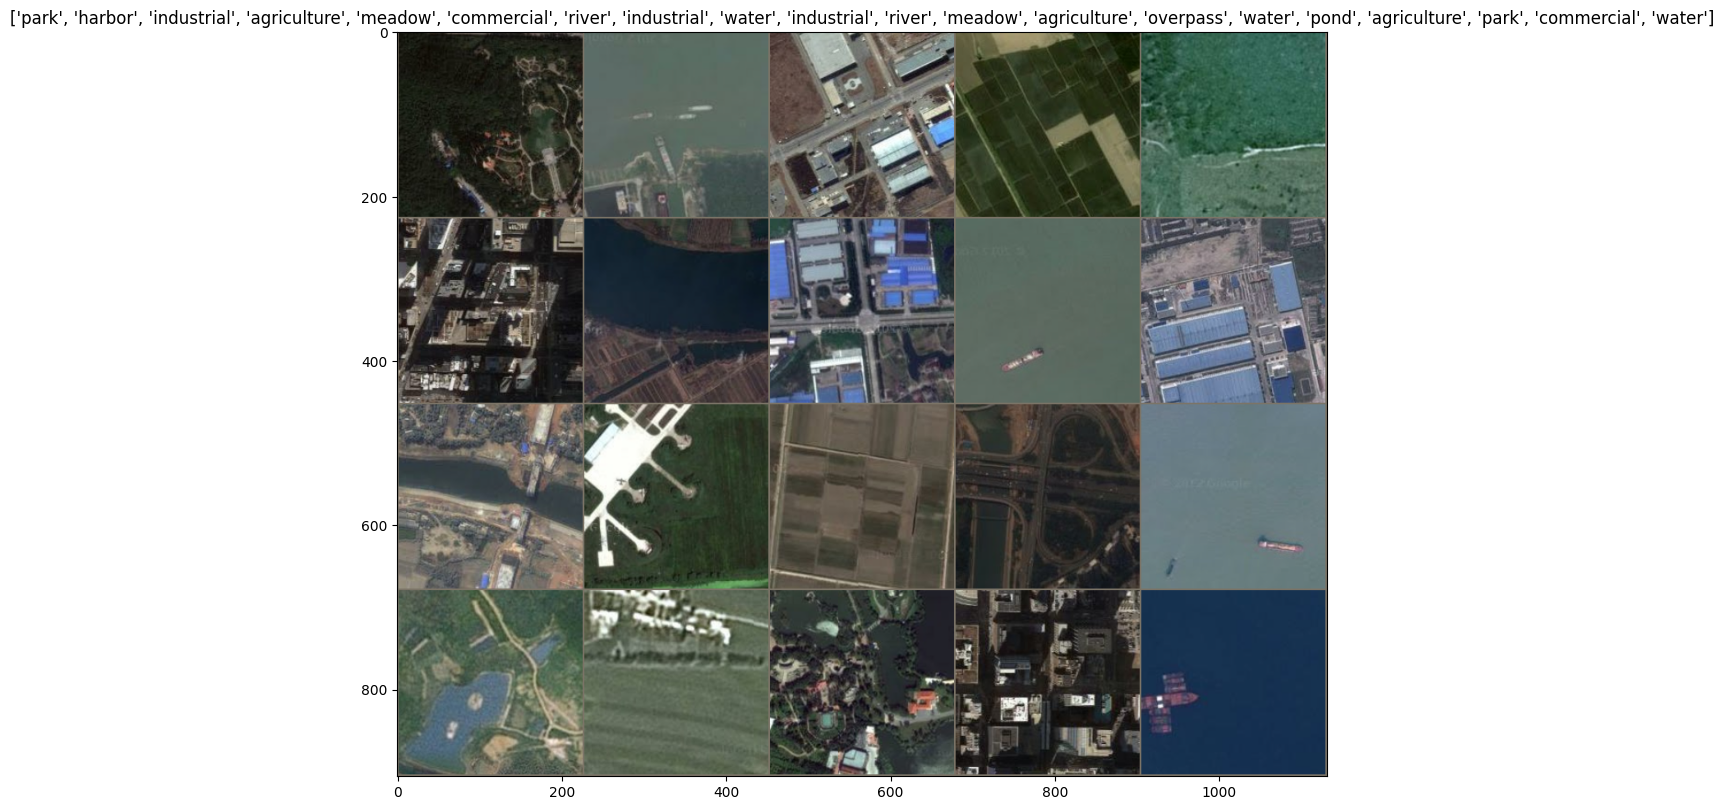

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# 获取一个 batch 的训练数据
inputs, classes = next(iter(train_loader))

# 制作网格
out = torchvision.utils.make_grid(inputs[:20], nrow=5) # 展示前20张

plt.figure(figsize=(12, 12))
imshow(out, title=[class_names[x] for x in classes[:20]])

## 4. 定义 PyTorch Lightning 模块

使用 `timm` 创建骨干网络，并封装在 `LightningModule` 中。
支持模型名称作为参数传入，例如 `resnet50`, `vit_base_patch16_224`, `googlenet` (inception_v3) 等。

In [10]:
class SceneClassifier(pl.LightningModule):
    def __init__(self, model_name='resnet50', num_classes=12, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # 使用 timm 创建模型，pretrained=True 使用 ImageNet 预训练权重
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
        
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # 计算准确率
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        return {'loss': loss, 'preds': preds, 'targets': y}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return [optimizer], [scheduler]

## 5. 模型训练配置与回调函数

配置 Trainer，设置 Checkpoint 保存最佳模型，设置 EarlyStopping 防止过拟合。
你可以修改 `MODEL_NAME` 来切换不同的骨干网络，例如：
- `resnet50`
- `vit_base_patch16_224`
- `googlenet`
- `densenet121`
- `efficientnet_b0`

In [26]:
timm.list_models()  # 列出所有可用的预训练模型

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit3_base_patch16_224',
 'beit3_giant_patch14_224',
 'beit3_giant_patch14_336',
 'beit3_large_patch16_224',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_sma

In [27]:
# 模型名称
MODEL_NAME = 'convnext_base' # 尝试修改为 'vit_base_patch16_224' 或其他
MAX_EPOCHS = 20
LEARNING_RATE = 1e-4

# 回调函数
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints',
    filename=f'{MODEL_NAME}-{{epoch:02d}}-{{val_acc:.2f}}',
    save_top_k=1,
    mode='max',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=True,
    mode='min'
)

# Logger
logger = TensorBoardLogger("lightning_logs", name=MODEL_NAME)

# 实例化模型
model = SceneClassifier(model_name=MODEL_NAME, num_classes=len(class_names), lr=LEARNING_RATE)

# 实例化 Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='auto', # 自动检测 GPU/CPU
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10
)

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

d:\miniconda3\envs\torch\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\1\.cache\huggingface\hub\models--timm--convnext_base.fb_in22k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [28]:
model.model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

## 6. 模型训练与验证

开始训练模型。训练过程中会自动在验证集上进行评估。

In [ ]:
# 开始训练
trainer.fit(model, train_loader, val_loader)

d:\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory D:\Project\图像理解作业\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | ConvNeXt         | 87.6 M | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
87.6 M    Trainable params
0         Non-trainable params
87.6 M    Total params
350.315   Total estimated model params size (MB)
466       Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
d:\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

## 7. 训练过程可视化 (TensorBoard)

在 Notebook 中直接加载 TensorBoard 查看训练曲线。
如果无法显示，请在终端运行 `tensorboard --logdir lightning_logs` 并在浏览器访问。

## 8. 模型评估与混淆矩阵可视化

加载最佳模型权重，在测试集上进行评估，并绘制混淆矩阵。

Best model path: D:\Project\图像理解作业\checkpoints\resnet50-epoch=13-val_acc=0.94.ckpt


100%|██████████| 15/15 [00:01<00:00,  7.60it/s]


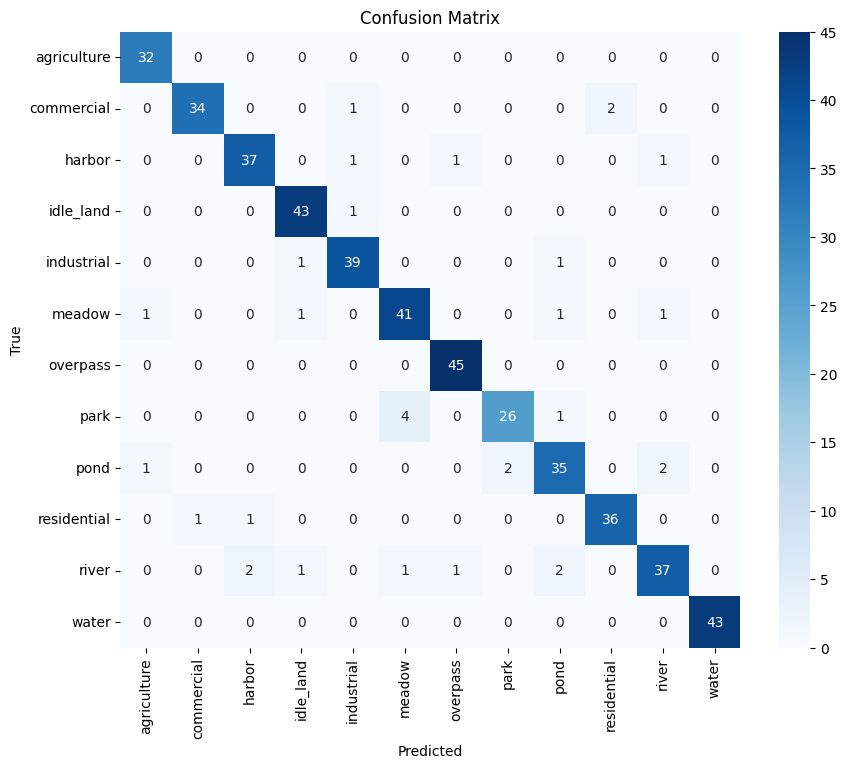

              precision    recall  f1-score   support

 agriculture       0.94      1.00      0.97        32
  commercial       0.97      0.92      0.94        37
      harbor       0.93      0.93      0.93        40
   idle_land       0.93      0.98      0.96        44
  industrial       0.93      0.95      0.94        41
      meadow       0.89      0.91      0.90        45
    overpass       0.96      1.00      0.98        45
        park       0.93      0.84      0.88        31
        pond       0.88      0.88      0.88        40
 residential       0.95      0.95      0.95        38
       river       0.90      0.84      0.87        44
       water       1.00      1.00      1.00        43

    accuracy                           0.93       480
   macro avg       0.93      0.93      0.93       480
weighted avg       0.93      0.93      0.93       480



In [23]:
# 加载最佳模型
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

best_model = SceneClassifier.load_from_checkpoint(best_model_path)
best_model.eval()
best_model.to(device)

# 在测试集上进行预测
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.to(device)
        logits = best_model(x)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# 计算混淆矩阵
cm = confusion_matrix(all_targets, all_preds)

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print(classification_report(all_targets, all_preds, target_names=class_names))

## 9. 预测结果展示

随机抽取测试集样本，展示预测结果。

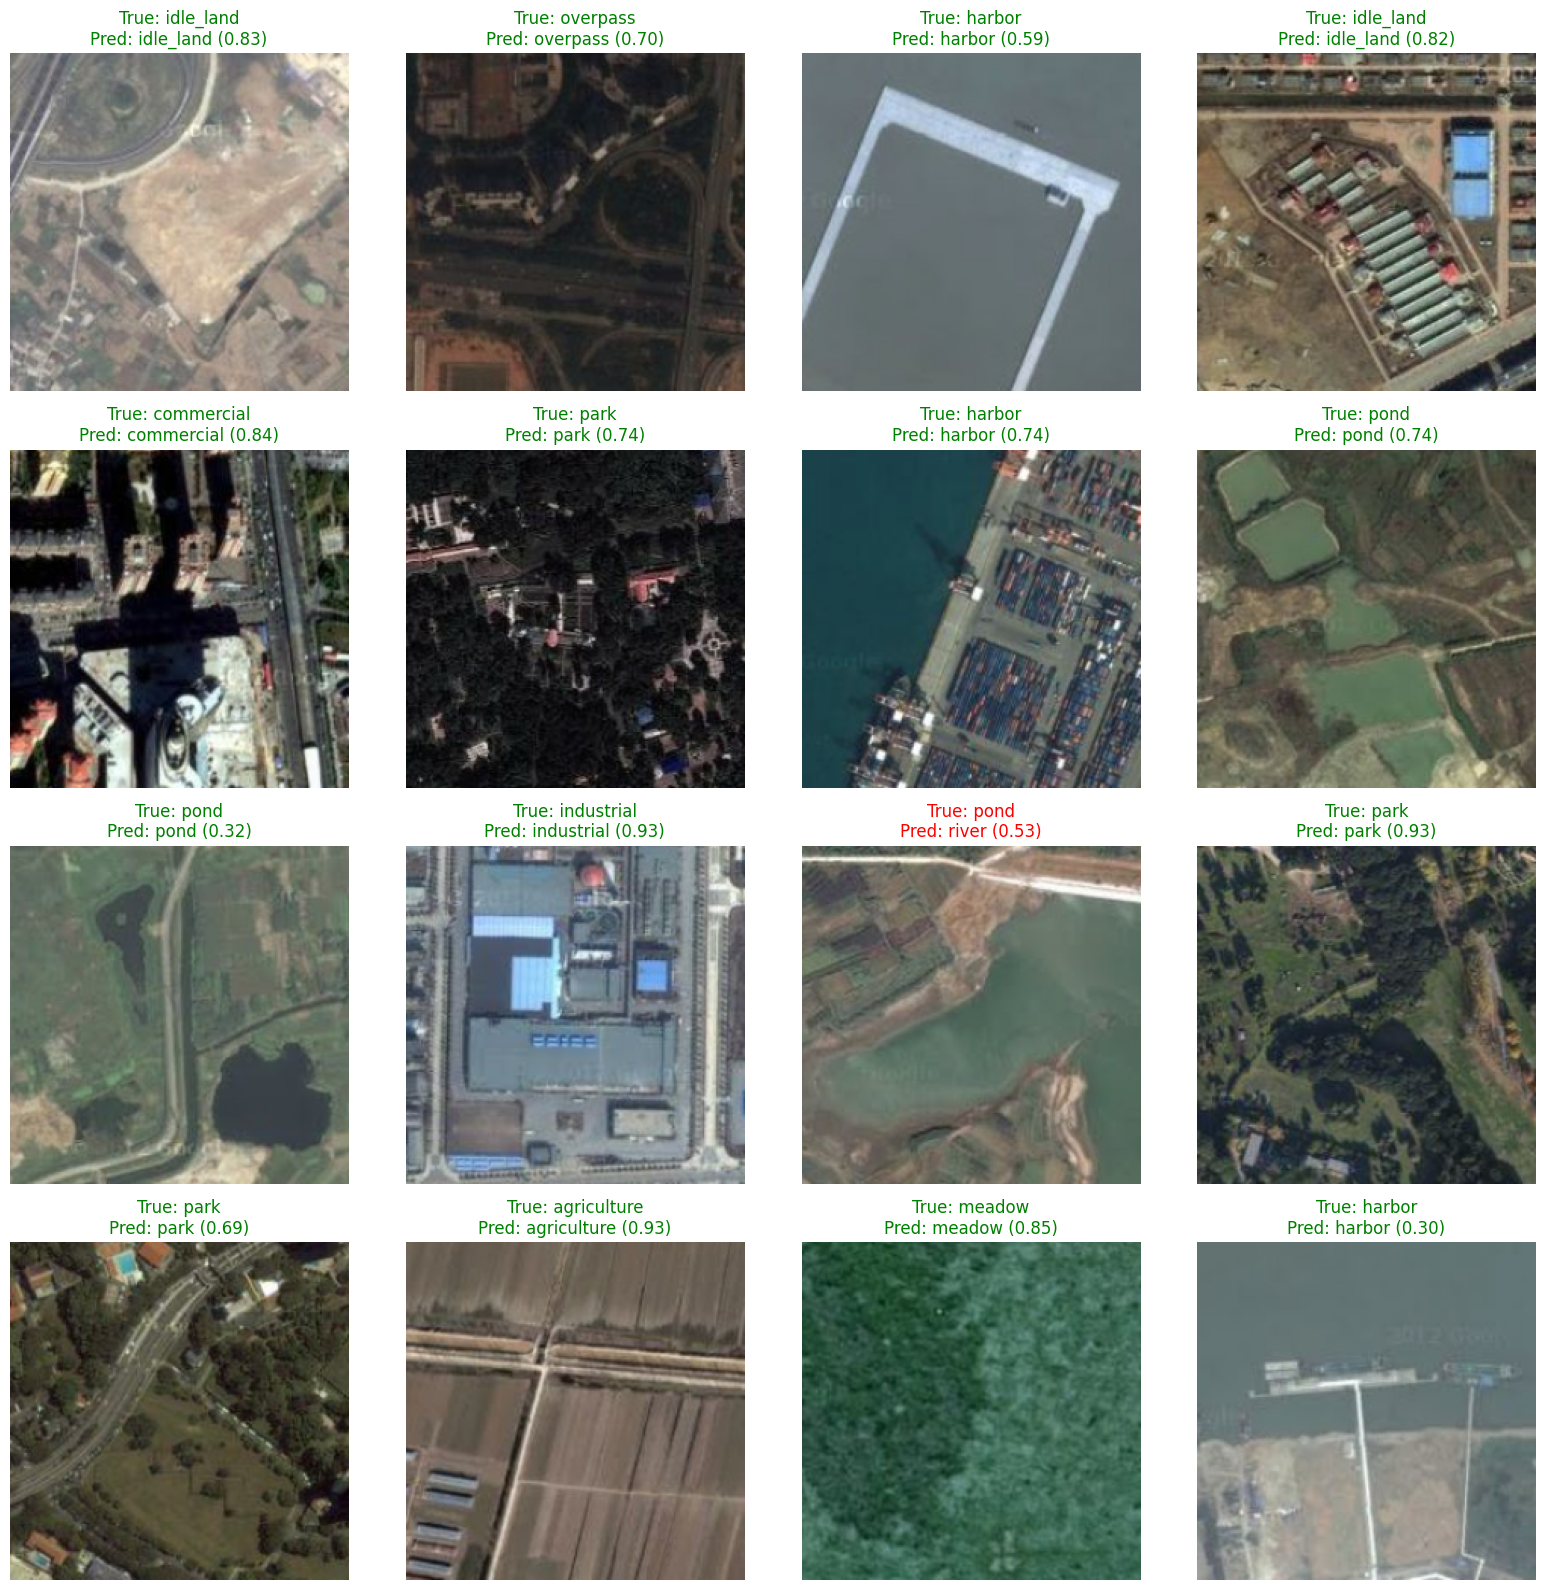

In [24]:
# 获取一个 batch 的测试数据
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)

# 预测
with torch.no_grad():
    logits = best_model(inputs)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

# 移动回 CPU
inputs = inputs.cpu()
preds = preds.cpu()
targets = targets.cpu()
probs = probs.cpu()

# 展示前 16 张
plt.figure(figsize=(16, 16))
for i in range(16):
    if i >= len(inputs):
        break
    ax = plt.subplot(4, 4, i + 1)
    
    img = inputs[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    
    true_label = class_names[targets[i]]
    pred_label = class_names[preds[i]]
    confidence = probs[i][preds[i]].item()
    
    color = 'green' if true_label == pred_label else 'red'
    
    plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()